In this notebook, we translate time-varying CO2 saturation in the rocks to the time-varying acoustic properties of the rock, e.g. velocity and density, via patchy saturation model.

Again we load some packages

In [1]:
using Seis4CCS.RockPhysics, JLD2, JUDI, Polynomials, PyPlot, SlimPlotting;

load the model

In [2]:
JLD2.@load "Compass2km.jld2"

5-element Vector{Symbol}:
 :n
 :d
 :o
 :v
 :rho

load the CO2 saturation

In [3]:
JLD2.@load "S.jld2"

2-element Vector{Symbol}:
 :S
 :p

we can again translate the original velocity to permeability and porosity, following the previous notebook

In [4]:
K = VtoK(v, d);
ϕ = Ktoϕ(K, d);

we use the `Patchy` function from Seis4CCS.jl to convert the time-varying CO2 concentration to time-varying velocity and density.

In [5]:
v_stack, rho_stack = Patchy(S, v, rho, ϕ, d);

Let's check what they look like

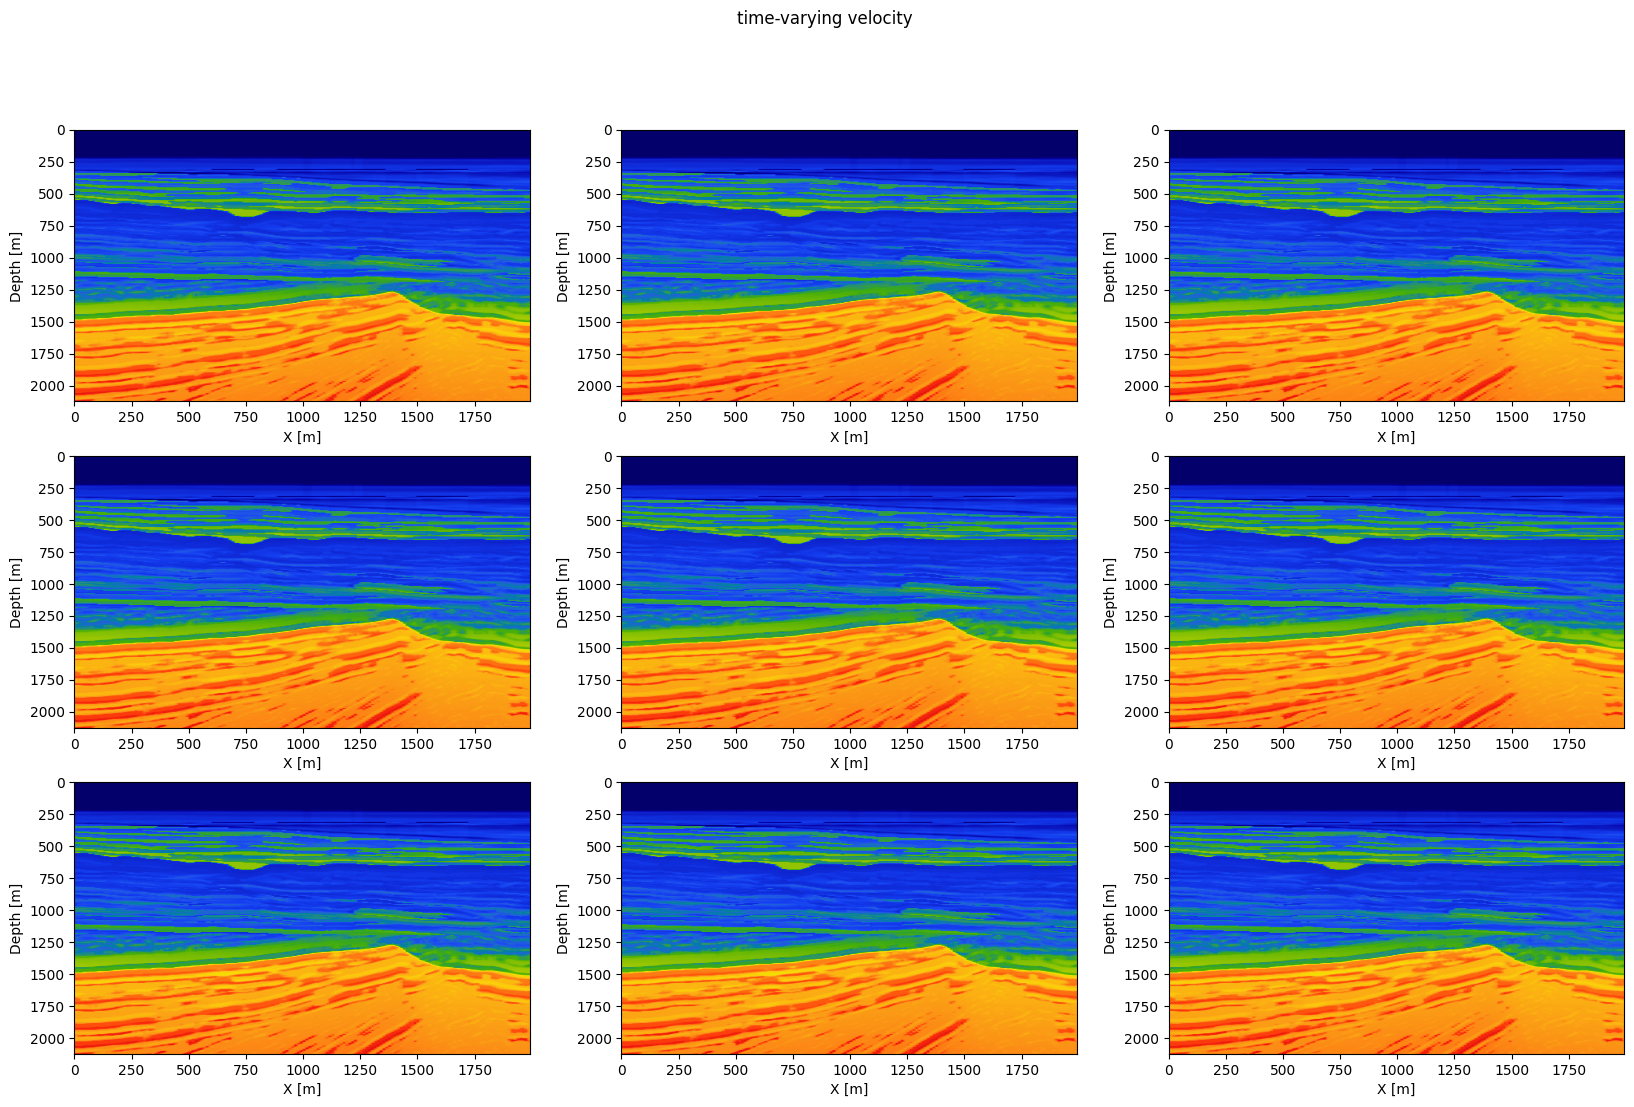

In [6]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=length(v_stack), length=9)));   # 9 observed time samples
for i = 1:9
    subplot(3,3,i)
    plot_velocity(v_stack[obs[i]]', d; name="", new_fig=false);
end
suptitle("time-varying velocity");

It's really hard to see the CO2-induced change of velocity since it is quite subtle! Let's plot the subtractions instead.

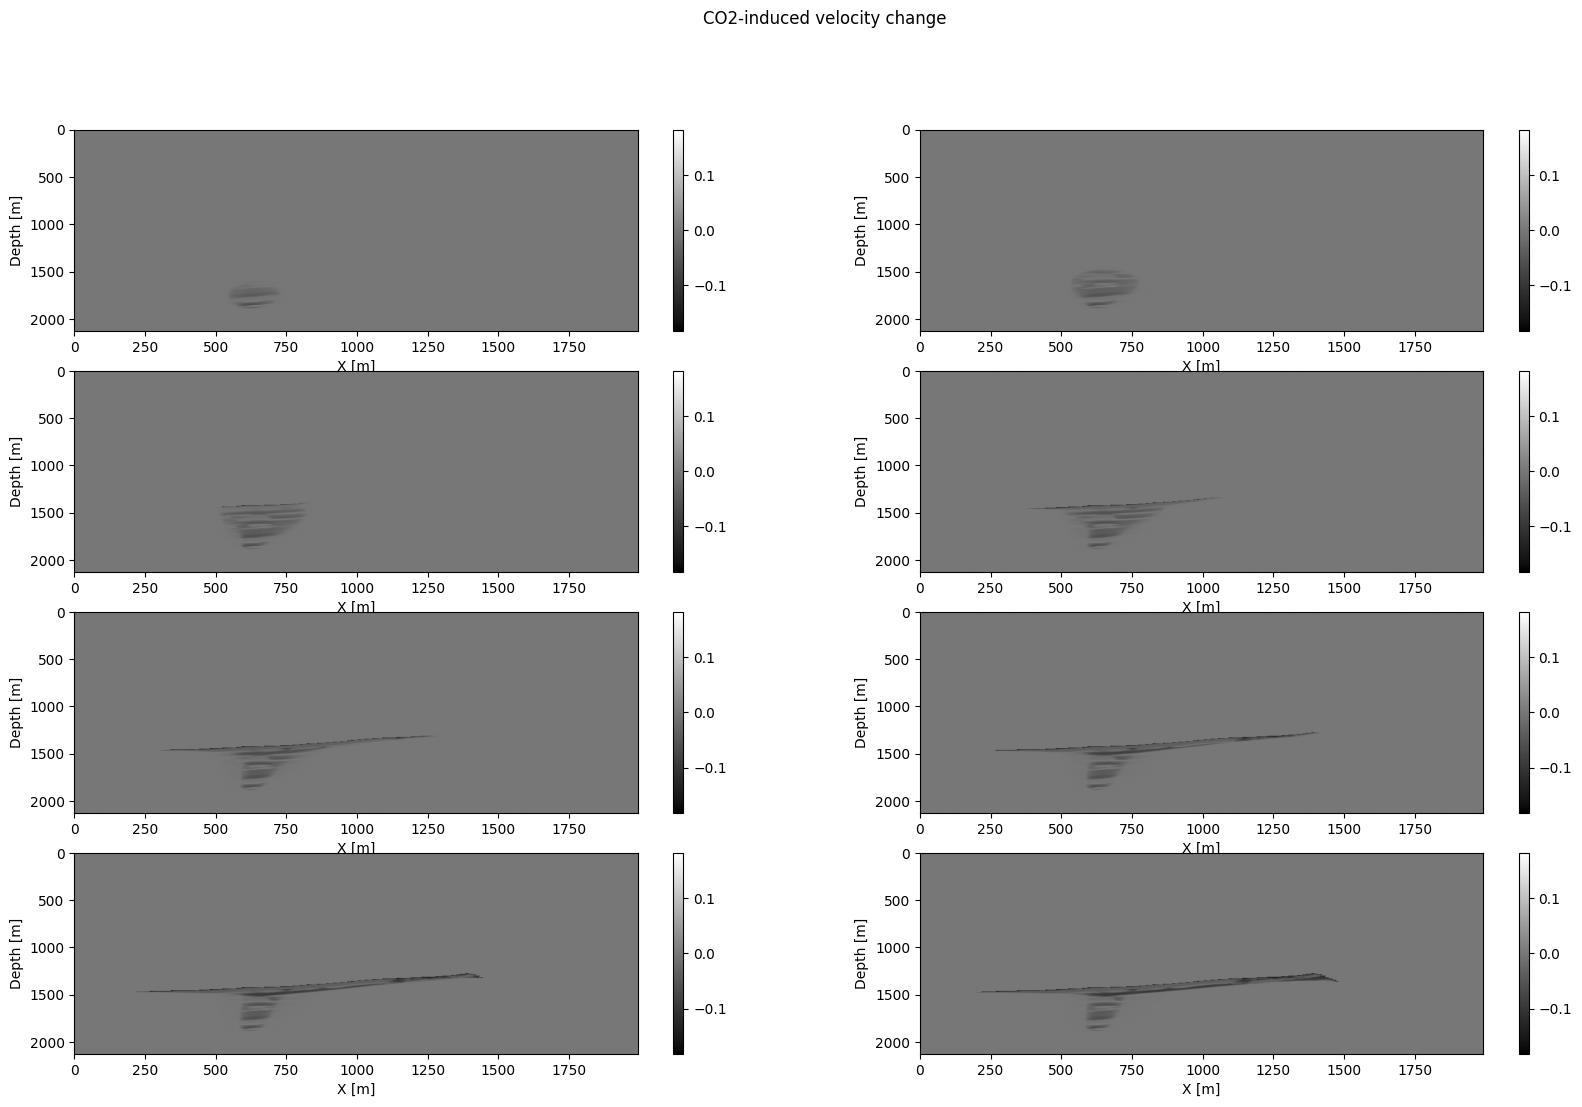

In [7]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=length(v_stack), length=9)));   # 9 observed time samples
for i = 1:8
    subplot(4,2,i)
    plot_simage(v_stack[obs[i+1]]'-v_stack[obs[1]]', d; name="", vmax=maximum(v_stack[1]-v_stack[end]), new_fig=false);
    colorbar();
end
suptitle("CO2-induced velocity change");

Let's then plot the decrease of density

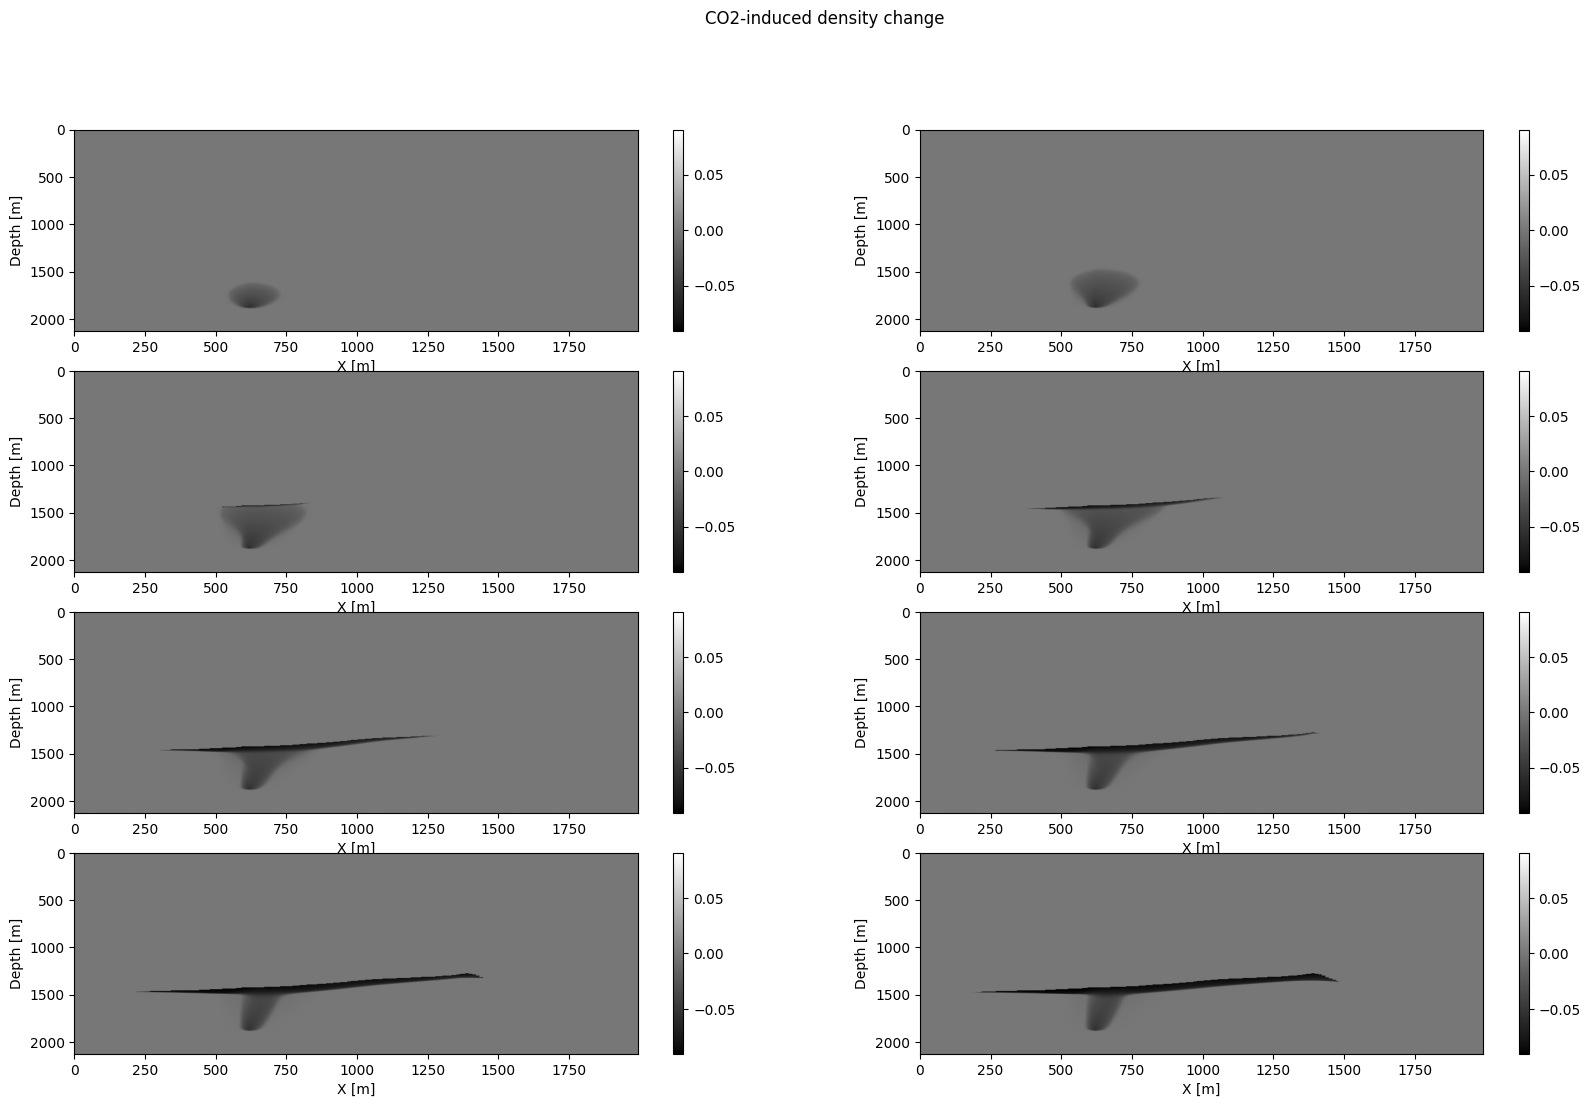

In [8]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=length(rho_stack), length=9)));   # 9 observed time samples
for i = 1:8
    subplot(4,2,i)
    plot_simage(rho_stack[obs[i+1]]'-rho_stack[obs[1]]', d; name="", vmax=maximum(rho_stack[1]-rho_stack[end]), new_fig=false);
    colorbar();
end
suptitle("CO2-induced density change");

As a reference, the CO2 saturation is shown below

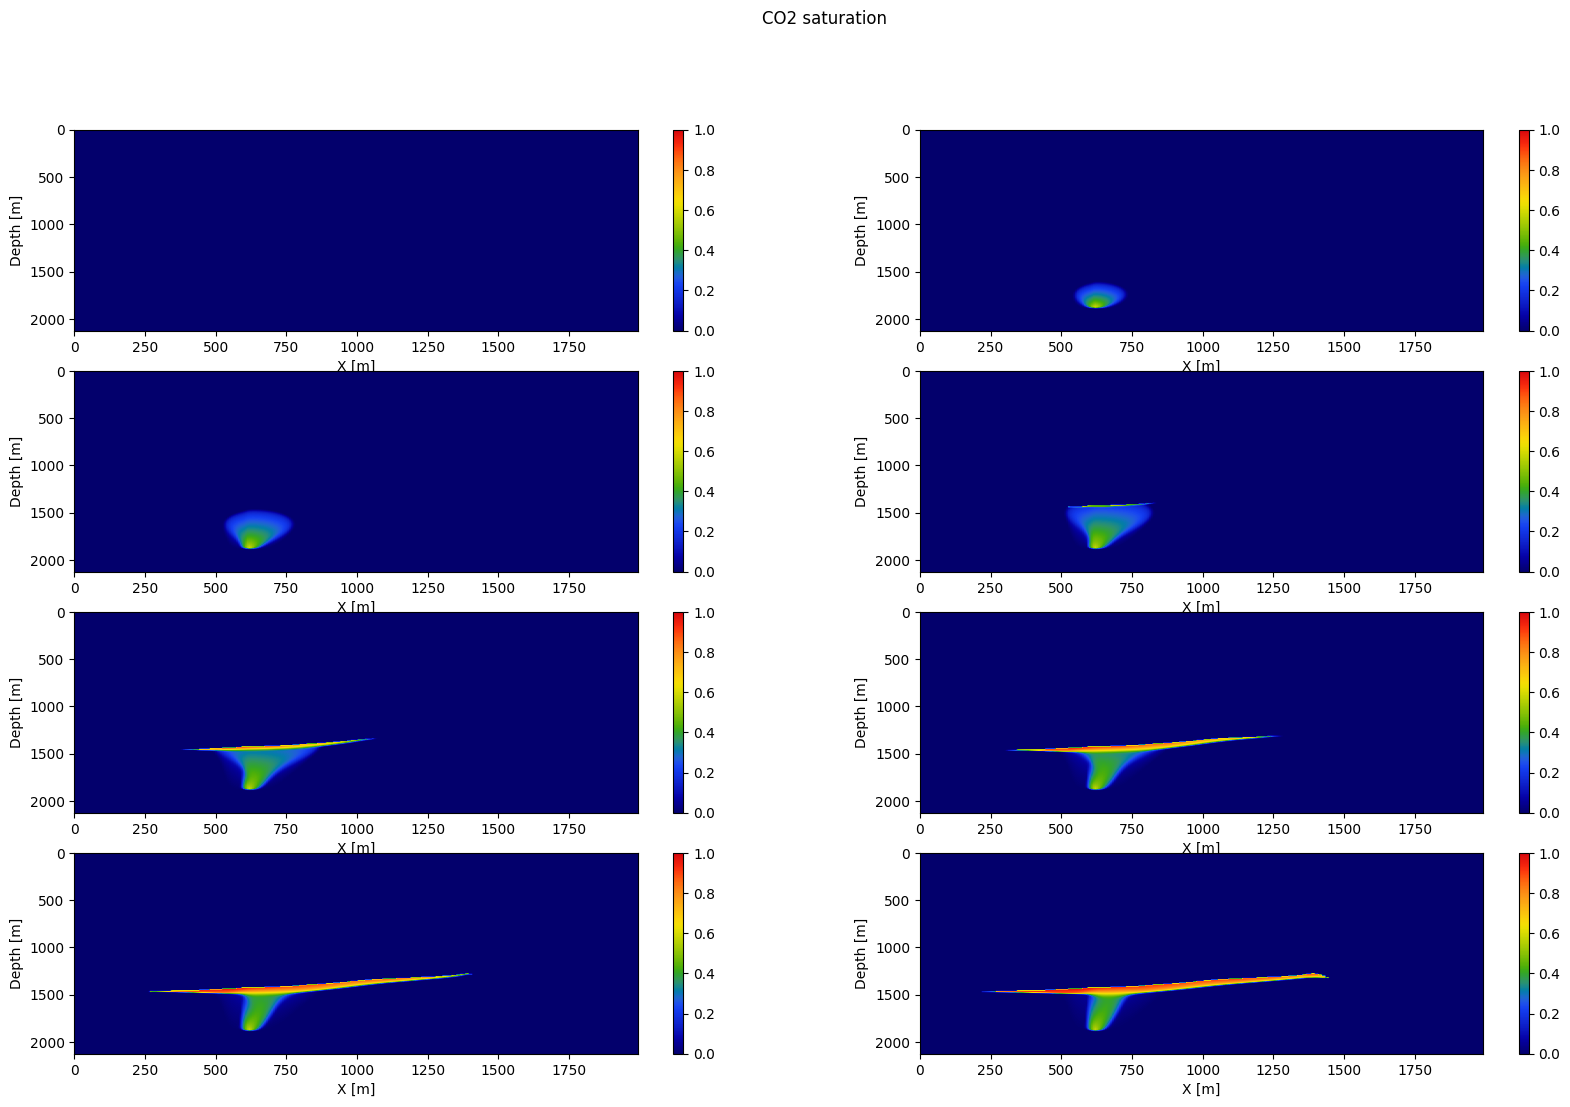

In [9]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=size(S,1), length=9)))[1:8];   # 8 observed time samples
for i = 1:8
    subplot(4,2,i)
    plot_velocity(S[obs[i],:,:]', d; name="", vmax=1, new_fig=false);
    colorbar();
end
suptitle("CO2 saturation");

In [10]:
JLD2.@save "timelapsevrho.jld2" v_stack rho_stack